### Cab-Driver Agent

In [27]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [28]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print("\nData shape:\n", np.shape(Time_matrix))
print("dimensions = ",len(Time_matrix.shape))


Data shape:
 (5, 5, 24, 7)
dimensions =  4


#### Tracking the state-action pairs for checking convergence


In [29]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [30]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        #self.discount_factor =0.9
        self.discount_factor =0.95

        #self.learning_rate =0.001
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay =  .995
        #self.epsilon_decay = -0.0005
        self.epsilon_decay =  .999
        #self.epsilon_min = 0.001
        self.epsilon_min = 0.00001

        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            return random.sample(possible_actions_index,1)[0]
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]    
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [31]:
Episodes = 5000

### DQN block

In [32]:
#Under Test
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [1, 8, 6]
episode 0, reward -238.0, memory_length 129, epsilon 0.999, time 726.0, rides 128
Initial State is  [2, 14, 4]
episode 1, reward -280.0, memory_length 261, epsilon 0.998001, time 729.0, rides 131
Initial State is  [4, 1, 0]
episode 2, reward -81.0, memory_length 408, epsilon 0.997002999, time 727.0, rides 146
Initial State is  [2, 5, 5]
episode 3, reward -387.0, memory_length 534, epsilon 0.996005996001, time 730.0, rides 125
Initial State is  [3, 18, 2]
episode 4, reward -46.0, memory_length 661, epsilon 0.995009990004999, time 734.0, rides 126
Initial State is  [4, 17, 5]
episode 5, reward -136.0, memory_length 786, epsilon 0.994014980014994, time 729.0, rides 124
Initial State is  [0, 19, 2]
episode 6, reward -308.0, memory_length 913, epsilon 0.993020965034979, time 731.0, rides 126
Initial State is  [1, 7, 3]
episode 7, reward -370.0, memory_length 1034, epsilon 0.9920279440699441, time 731.0, rides 120
Initial State is  [3, 18, 1]
episode 8, reward -42

episode 66, reward -49.0, memory_length 2000, epsilon 0.9351638519212846, time 736.0, rides 130
Initial State is  [2, 18, 4]
episode 67, reward -228.0, memory_length 2000, epsilon 0.9342286880693633, time 726.0, rides 121
Initial State is  [0, 11, 2]
episode 68, reward -91.0, memory_length 2000, epsilon 0.933294459381294, time 728.0, rides 129
Initial State is  [3, 11, 2]
episode 69, reward -161.0, memory_length 2000, epsilon 0.9323611649219127, time 732.0, rides 128
Initial State is  [4, 15, 0]
episode 70, reward -131.0, memory_length 2000, epsilon 0.9314288037569908, time 721.0, rides 124
Initial State is  [2, 9, 1]
episode 71, reward 43.0, memory_length 2000, epsilon 0.9304973749532338, time 726.0, rides 116
Initial State is  [1, 17, 4]
episode 72, reward -253.0, memory_length 2000, epsilon 0.9295668775782806, time 725.0, rides 113
Initial State is  [3, 16, 3]
episode 73, reward -300.0, memory_length 2000, epsilon 0.9286373107007023, time 729.0, rides 118
Initial State is  [0, 17, 6

episode 132, reward 68.0, memory_length 2000, epsilon 0.8754068367770318, time 729.0, rides 126
Initial State is  [0, 22, 4]
episode 133, reward -43.0, memory_length 2000, epsilon 0.8745314299402548, time 737.0, rides 120
Initial State is  [0, 3, 3]
episode 134, reward -89.0, memory_length 2000, epsilon 0.8736568985103146, time 724.0, rides 110
Initial State is  [1, 6, 3]
episode 135, reward -62.0, memory_length 2000, epsilon 0.8727832416118043, time 729.0, rides 113
Initial State is  [4, 0, 2]
episode 136, reward -152.0, memory_length 2000, epsilon 0.8719104583701925, time 734.0, rides 135
Initial State is  [1, 17, 5]
episode 137, reward 152.0, memory_length 2000, epsilon 0.8710385479118223, time 727.0, rides 124
Initial State is  [0, 5, 4]
episode 138, reward -27.0, memory_length 2000, epsilon 0.8701675093639105, time 733.0, rides 124
Initial State is  [2, 10, 5]
episode 139, reward -59.0, memory_length 2000, epsilon 0.8692973418545467, time 722.0, rides 123
Initial State is  [4, 8, 

episode 198, reward -206.0, memory_length 2000, epsilon 0.8194682977764125, time 726.0, rides 130
Initial State is  [1, 19, 2]
episode 199, reward -72.0, memory_length 2000, epsilon 0.818648829478636, time 730.0, rides 113
Initial State is  [3, 20, 0]
episode 200, reward -96.0, memory_length 2000, epsilon 0.8178301806491574, time 733.0, rides 130
Initial State is  [3, 3, 3]
episode 201, reward -31.0, memory_length 2000, epsilon 0.8170123504685082, time 742.0, rides 131
Initial State is  [0, 4, 0]
episode 202, reward -248.0, memory_length 2000, epsilon 0.8161953381180397, time 731.0, rides 135
Initial State is  [4, 10, 2]
episode 203, reward -268.0, memory_length 2000, epsilon 0.8153791427799216, time 735.0, rides 128
Initial State is  [3, 10, 1]
episode 204, reward -81.0, memory_length 2000, epsilon 0.8145637636371417, time 730.0, rides 131
Initial State is  [4, 6, 2]
episode 205, reward -381.0, memory_length 2000, epsilon 0.8137491998735046, time 732.0, rides 129
Initial State is  [1,

episode 264, reward -76.0, memory_length 2000, epsilon 0.7671042341100781, time 722.0, rides 117
Initial State is  [1, 10, 0]
episode 265, reward -193.0, memory_length 2000, epsilon 0.766337129875968, time 725.0, rides 116
Initial State is  [1, 8, 1]
episode 266, reward -141.0, memory_length 2000, epsilon 0.7655707927460921, time 726.0, rides 124
Initial State is  [1, 12, 0]
episode 267, reward -16.0, memory_length 2000, epsilon 0.764805221953346, time 733.0, rides 134
Initial State is  [4, 22, 4]
episode 268, reward -110.0, memory_length 2000, epsilon 0.7640404167313927, time 728.0, rides 128
Initial State is  [0, 12, 1]
episode 269, reward -62.0, memory_length 2000, epsilon 0.7632763763146613, time 733.0, rides 115
Initial State is  [0, 17, 5]
episode 270, reward -205.0, memory_length 2000, epsilon 0.7625130999383466, time 723.0, rides 114
Initial State is  [0, 18, 6]
episode 271, reward 96.0, memory_length 2000, epsilon 0.7617505868384082, time 733.0, rides 127
Initial State is  [4,

episode 330, reward 90.0, memory_length 2000, epsilon 0.7180862366321393, time 726.0, rides 124
Initial State is  [2, 2, 0]
episode 331, reward 97.0, memory_length 2000, epsilon 0.7173681503955072, time 732.0, rides 127
Initial State is  [4, 2, 3]
episode 332, reward 65.0, memory_length 2000, epsilon 0.7166507822451117, time 722.0, rides 111
Initial State is  [4, 12, 1]
episode 333, reward -162.0, memory_length 2000, epsilon 0.7159341314628666, time 728.0, rides 128
Initial State is  [3, 20, 6]
episode 334, reward -165.0, memory_length 2000, epsilon 0.7152181973314037, time 724.0, rides 133
Initial State is  [1, 13, 0]
episode 335, reward -28.0, memory_length 2000, epsilon 0.7145029791340722, time 726.0, rides 130
Initial State is  [1, 23, 5]
episode 336, reward 80.0, memory_length 2000, epsilon 0.7137884761549381, time 730.0, rides 133
Initial State is  [1, 17, 5]
episode 337, reward 110.0, memory_length 2000, epsilon 0.7130746876787832, time 732.0, rides 125
Initial State is  [0, 3, 

episode 396, reward 417.0, memory_length 2000, epsilon 0.6722004915521225, time 729.0, rides 125
Initial State is  [2, 7, 3]
episode 397, reward 237.0, memory_length 2000, epsilon 0.6715282910605703, time 731.0, rides 117
Initial State is  [3, 23, 1]
episode 398, reward 70.0, memory_length 2000, epsilon 0.6708567627695098, time 724.0, rides 131
Initial State is  [3, 15, 3]
episode 399, reward 247.0, memory_length 2000, epsilon 0.6701859060067403, time 724.0, rides 131
Initial State is  [4, 5, 0]
episode 400, reward -12.0, memory_length 2000, epsilon 0.6695157201007336, time 728.0, rides 120
Initial State is  [4, 8, 5]
episode 401, reward 126.0, memory_length 2000, epsilon 0.6688462043806328, time 734.0, rides 126
Initial State is  [2, 22, 5]
episode 402, reward -227.0, memory_length 2000, epsilon 0.6681773581762521, time 732.0, rides 121
Initial State is  [1, 12, 2]
episode 403, reward 25.0, memory_length 2000, epsilon 0.6675091808180759, time 734.0, rides 125
Initial State is  [3, 16,

episode 462, reward 219.0, memory_length 2000, epsilon 0.6292468477910546, time 731.0, rides 131
Initial State is  [4, 7, 1]
episode 463, reward -96.0, memory_length 2000, epsilon 0.6286176009432635, time 729.0, rides 115
Initial State is  [0, 10, 2]
episode 464, reward 115.0, memory_length 2000, epsilon 0.6279889833423202, time 733.0, rides 121
Initial State is  [2, 13, 1]
episode 465, reward 259.0, memory_length 2000, epsilon 0.6273609943589779, time 727.0, rides 125
Initial State is  [0, 6, 2]
episode 466, reward -129.0, memory_length 2000, epsilon 0.6267336333646188, time 729.0, rides 132
Initial State is  [3, 18, 5]
episode 467, reward 309.0, memory_length 2000, epsilon 0.6261068997312542, time 726.0, rides 121
Initial State is  [1, 7, 1]
episode 468, reward 145.0, memory_length 2000, epsilon 0.6254807928315229, time 731.0, rides 122
Initial State is  [2, 6, 4]
episode 469, reward -247.0, memory_length 2000, epsilon 0.6248553120386914, time 735.0, rides 117
Initial State is  [1, 1

episode 528, reward 12.0, memory_length 2000, epsilon 0.5890379439335424, time 739.0, rides 134
Initial State is  [4, 14, 3]
episode 529, reward 174.0, memory_length 2000, epsilon 0.5884489059896089, time 726.0, rides 122
Initial State is  [3, 12, 2]
episode 530, reward 320.0, memory_length 2000, epsilon 0.5878604570836192, time 735.0, rides 132
Initial State is  [1, 5, 0]
episode 531, reward 230.0, memory_length 2000, epsilon 0.5872725966265356, time 727.0, rides 119
Initial State is  [3, 21, 1]
episode 532, reward 5.0, memory_length 2000, epsilon 0.5866853240299091, time 727.0, rides 122
Initial State is  [2, 17, 2]
episode 533, reward 156.0, memory_length 2000, epsilon 0.5860986387058792, time 725.0, rides 144
Initial State is  [4, 18, 5]
episode 534, reward 242.0, memory_length 2000, epsilon 0.5855125400671733, time 735.0, rides 123
Initial State is  [4, 18, 0]
episode 535, reward -2.0, memory_length 2000, epsilon 0.5849270275271061, time 724.0, rides 125
Initial State is  [4, 12, 

episode 594, reward 190.0, memory_length 2000, epsilon 0.5513983909676525, time 735.0, rides 124
Initial State is  [1, 13, 5]
episode 595, reward 125.0, memory_length 2000, epsilon 0.5508469925766849, time 735.0, rides 110
Initial State is  [1, 3, 2]
episode 596, reward 38.0, memory_length 2000, epsilon 0.5502961455841082, time 729.0, rides 116
Initial State is  [4, 3, 1]
episode 597, reward 346.0, memory_length 2000, epsilon 0.5497458494385241, time 723.0, rides 119
Initial State is  [4, 17, 6]
episode 598, reward 131.0, memory_length 2000, epsilon 0.5491961035890855, time 734.0, rides 131
Initial State is  [0, 23, 2]
episode 599, reward 118.0, memory_length 2000, epsilon 0.5486469074854965, time 726.0, rides 126
Initial State is  [1, 18, 5]
episode 600, reward 466.0, memory_length 2000, epsilon 0.548098260578011, time 738.0, rides 126
Initial State is  [0, 15, 4]
episode 601, reward 460.0, memory_length 2000, epsilon 0.547550162317433, time 725.0, rides 119
Initial State is  [1, 16, 

episode 660, reward -57.0, memory_length 2000, epsilon 0.5161640072477562, time 730.0, rides 110
Initial State is  [0, 13, 6]
episode 661, reward 143.0, memory_length 2000, epsilon 0.5156478432405085, time 732.0, rides 119
Initial State is  [0, 7, 3]
episode 662, reward 183.0, memory_length 2000, epsilon 0.515132195397268, time 733.0, rides 130
Initial State is  [1, 14, 0]
episode 663, reward 163.0, memory_length 2000, epsilon 0.5146170632018707, time 736.0, rides 128
Initial State is  [4, 20, 4]
episode 664, reward -58.0, memory_length 2000, epsilon 0.5141024461386688, time 728.0, rides 114
Initial State is  [4, 10, 2]
episode 665, reward 212.0, memory_length 2000, epsilon 0.5135883436925301, time 731.0, rides 125
Initial State is  [2, 1, 4]
episode 666, reward -23.0, memory_length 2000, epsilon 0.5130747553488376, time 729.0, rides 121
Initial State is  [0, 4, 6]
episode 667, reward 108.0, memory_length 2000, epsilon 0.5125616805934888, time 739.0, rides 134
Initial State is  [0, 9, 

episode 726, reward 101.0, memory_length 2000, epsilon 0.4831811023432807, time 742.0, rides 124
Initial State is  [3, 21, 0]
episode 727, reward 161.0, memory_length 2000, epsilon 0.4826979212409374, time 732.0, rides 125
Initial State is  [0, 11, 1]
episode 728, reward 191.0, memory_length 2000, epsilon 0.48221522331969646, time 732.0, rides 127
Initial State is  [2, 0, 4]
episode 729, reward 224.0, memory_length 2000, epsilon 0.48173300809637676, time 730.0, rides 127
Initial State is  [1, 5, 6]
episode 730, reward 136.0, memory_length 2000, epsilon 0.48125127508828036, time 732.0, rides 115
Initial State is  [1, 10, 4]
episode 731, reward 150.0, memory_length 2000, epsilon 0.48077002381319206, time 727.0, rides 123
Initial State is  [0, 11, 2]
episode 732, reward 94.0, memory_length 2000, epsilon 0.48028925378937887, time 728.0, rides 144
Initial State is  [3, 6, 5]
episode 733, reward 388.0, memory_length 2000, epsilon 0.47980896453558947, time 731.0, rides 132
Initial State is  [

episode 792, reward 53.0, memory_length 2000, epsilon 0.4523058066495642, time 742.0, rides 114
Initial State is  [3, 19, 5]
episode 793, reward 60.0, memory_length 2000, epsilon 0.45185350084291465, time 737.0, rides 134
Initial State is  [4, 13, 2]
episode 794, reward 278.0, memory_length 2000, epsilon 0.4514016473420717, time 727.0, rides 111
Initial State is  [0, 13, 6]
episode 795, reward 277.0, memory_length 2000, epsilon 0.45095024569472963, time 727.0, rides 124
Initial State is  [1, 14, 6]
episode 796, reward 166.0, memory_length 2000, epsilon 0.4504992954490349, time 745.0, rides 114
Initial State is  [4, 19, 1]
episode 797, reward 256.0, memory_length 2000, epsilon 0.45004879615358584, time 729.0, rides 132
Initial State is  [4, 23, 1]
episode 798, reward 128.0, memory_length 2000, epsilon 0.44959874735743227, time 729.0, rides 118
Initial State is  [2, 3, 4]
episode 799, reward -29.0, memory_length 2000, epsilon 0.4491491486100748, time 726.0, rides 119
Initial State is  [1

episode 858, reward 357.0, memory_length 2000, epsilon 0.4234034438366067, time 739.0, rides 118
Initial State is  [1, 0, 3]
episode 859, reward 625.0, memory_length 2000, epsilon 0.4229800403927701, time 732.0, rides 136
Initial State is  [2, 11, 3]
episode 860, reward 506.0, memory_length 2000, epsilon 0.42255706035237733, time 736.0, rides 124
Initial State is  [4, 3, 5]
episode 861, reward 464.0, memory_length 2000, epsilon 0.42213450329202495, time 729.0, rides 130
Initial State is  [4, 0, 1]
episode 862, reward 368.0, memory_length 2000, epsilon 0.4217123687887329, time 720.0, rides 121
Initial State is  [4, 20, 5]
episode 863, reward 88.0, memory_length 2000, epsilon 0.4212906564199442, time 727.0, rides 144
Initial State is  [0, 3, 1]
episode 864, reward 522.0, memory_length 2000, epsilon 0.42086936576352424, time 731.0, rides 128
Initial State is  [4, 23, 6]
episode 865, reward 469.0, memory_length 2000, epsilon 0.4204484963977607, time 736.0, rides 140
Initial State is  [4, 1

episode 924, reward 492.0, memory_length 2000, epsilon 0.3963479433983767, time 724.0, rides 125
Initial State is  [1, 7, 1]
episode 925, reward 248.0, memory_length 2000, epsilon 0.3959515954549783, time 725.0, rides 126
Initial State is  [0, 5, 2]
episode 926, reward 354.0, memory_length 2000, epsilon 0.39555564385952335, time 728.0, rides 115
Initial State is  [3, 2, 2]
episode 927, reward 476.0, memory_length 2000, epsilon 0.39516008821566384, time 728.0, rides 126
Initial State is  [1, 6, 5]
episode 928, reward 301.0, memory_length 2000, epsilon 0.3947649281274482, time 735.0, rides 124
Initial State is  [3, 15, 1]
episode 929, reward 267.0, memory_length 2000, epsilon 0.3943701631993207, time 744.0, rides 128
Initial State is  [0, 9, 3]
episode 930, reward 386.0, memory_length 2000, epsilon 0.3939757930361214, time 737.0, rides 118
Initial State is  [4, 19, 4]
episode 931, reward 493.0, memory_length 2000, epsilon 0.3935818172430853, time 730.0, rides 131
Initial State is  [4, 16

episode 990, reward 293.0, memory_length 2000, epsilon 0.37102129074024554, time 733.0, rides 127
Initial State is  [3, 2, 4]
episode 991, reward 103.0, memory_length 2000, epsilon 0.3706502694495053, time 733.0, rides 126
Initial State is  [1, 7, 0]
episode 992, reward 114.0, memory_length 2000, epsilon 0.3702796191800558, time 733.0, rides 117
Initial State is  [2, 3, 0]
episode 993, reward 567.0, memory_length 2000, epsilon 0.36990933956087574, time 733.0, rides 137
Initial State is  [3, 22, 6]
episode 994, reward 229.0, memory_length 2000, epsilon 0.36953943022131486, time 736.0, rides 125
Initial State is  [1, 5, 5]
episode 995, reward 490.0, memory_length 2000, epsilon 0.3691698907910935, time 721.0, rides 138
Initial State is  [1, 3, 4]
episode 996, reward 493.0, memory_length 2000, epsilon 0.3688007209003024, time 725.0, rides 122
Initial State is  [2, 3, 0]
episode 997, reward 141.0, memory_length 2000, epsilon 0.36843192017940213, time 734.0, rides 124
Initial State is  [0, 1

episode 1055, reward 337.0, memory_length 2000, epsilon 0.34766067307894, time 730.0, rides 129
Initial State is  [4, 15, 2]
episode 1056, reward 309.0, memory_length 2000, epsilon 0.34731301240586104, time 723.0, rides 131
Initial State is  [2, 12, 2]
episode 1057, reward 498.0, memory_length 2000, epsilon 0.3469656993934552, time 727.0, rides 128
Initial State is  [1, 7, 5]
episode 1058, reward 580.0, memory_length 2000, epsilon 0.3466187336940617, time 730.0, rides 126
Initial State is  [1, 11, 5]
episode 1059, reward 523.0, memory_length 2000, epsilon 0.34627211496036764, time 731.0, rides 133
Initial State is  [4, 6, 3]
episode 1060, reward 205.0, memory_length 2000, epsilon 0.3459258428454073, time 732.0, rides 126
Initial State is  [1, 0, 0]
episode 1061, reward 248.0, memory_length 2000, epsilon 0.34557991700256185, time 724.0, rides 123
Initial State is  [1, 5, 3]
episode 1062, reward 489.0, memory_length 2000, epsilon 0.3452343370855593, time 737.0, rides 121
Initial State is

episode 1120, reward 470.0, memory_length 2000, epsilon 0.325770910247633, time 728.0, rides 127
Initial State is  [0, 10, 5]
episode 1121, reward 455.0, memory_length 2000, epsilon 0.32544513933738534, time 727.0, rides 141
Initial State is  [1, 14, 5]
episode 1122, reward 237.0, memory_length 2000, epsilon 0.3251196941980479, time 732.0, rides 126
Initial State is  [4, 4, 5]
episode 1123, reward 318.0, memory_length 2000, epsilon 0.32479457450384985, time 729.0, rides 114
Initial State is  [0, 0, 6]
episode 1124, reward 362.0, memory_length 2000, epsilon 0.324469779929346, time 728.0, rides 127
Initial State is  [1, 13, 5]
episode 1125, reward 447.0, memory_length 2000, epsilon 0.32414531014941667, time 723.0, rides 134
Initial State is  [2, 0, 1]
episode 1126, reward 322.0, memory_length 2000, epsilon 0.32382116483926726, time 731.0, rides 128
Initial State is  [3, 16, 0]
episode 1127, reward 122.0, memory_length 2000, epsilon 0.323497343674428, time 732.0, rides 119
Initial State i

episode 1185, reward 524.0, memory_length 2000, epsilon 0.30525939279728115, time 729.0, rides 132
Initial State is  [2, 9, 3]
episode 1186, reward 305.0, memory_length 2000, epsilon 0.30495413340448385, time 731.0, rides 120
Initial State is  [4, 3, 6]
episode 1187, reward 550.0, memory_length 2000, epsilon 0.3046491792710794, time 732.0, rides 124
Initial State is  [1, 4, 2]
episode 1188, reward 432.0, memory_length 2000, epsilon 0.3043445300918083, time 731.0, rides 116
Initial State is  [4, 3, 3]
episode 1189, reward 485.0, memory_length 2000, epsilon 0.30404018556171647, time 733.0, rides 129
Initial State is  [0, 11, 5]
episode 1190, reward 611.0, memory_length 2000, epsilon 0.30373614537615473, time 723.0, rides 119
Initial State is  [1, 3, 5]
episode 1191, reward 327.0, memory_length 2000, epsilon 0.3034324092307786, time 724.0, rides 119
Initial State is  [4, 8, 5]
episode 1192, reward 201.0, memory_length 2000, epsilon 0.3031289768215478, time 724.0, rides 126
Initial State i

episode 1250, reward 163.0, memory_length 2000, epsilon 0.28603934224861294, time 742.0, rides 132
Initial State is  [2, 19, 1]
episode 1251, reward 140.0, memory_length 2000, epsilon 0.2857533029063643, time 730.0, rides 115
Initial State is  [2, 22, 0]
episode 1252, reward 419.0, memory_length 2000, epsilon 0.28546754960345794, time 735.0, rides 122
Initial State is  [1, 2, 0]
episode 1253, reward 389.0, memory_length 2000, epsilon 0.2851820820538545, time 733.0, rides 122
Initial State is  [0, 13, 1]
episode 1254, reward 464.0, memory_length 2000, epsilon 0.2848968999718006, time 734.0, rides 129
Initial State is  [1, 15, 1]
episode 1255, reward 224.0, memory_length 2000, epsilon 0.2846120030718288, time 722.0, rides 117
Initial State is  [4, 23, 1]
episode 1256, reward 473.0, memory_length 2000, epsilon 0.284327391068757, time 725.0, rides 118
Initial State is  [2, 15, 0]
episode 1257, reward 285.0, memory_length 2000, epsilon 0.2840430636776882, time 731.0, rides 125
Initial State

episode 1315, reward 149.0, memory_length 2000, epsilon 0.268029443956713, time 729.0, rides 117
Initial State is  [1, 13, 2]
episode 1316, reward 496.0, memory_length 2000, epsilon 0.2677614145127563, time 737.0, rides 137
Initial State is  [3, 7, 5]
episode 1317, reward 357.0, memory_length 2000, epsilon 0.2674936530982436, time 732.0, rides 111
Initial State is  [3, 12, 1]
episode 1318, reward 495.0, memory_length 2000, epsilon 0.26722615944514533, time 725.0, rides 122
Initial State is  [3, 6, 6]
episode 1319, reward 549.0, memory_length 2000, epsilon 0.2669589332857002, time 728.0, rides 115
Initial State is  [2, 20, 3]
episode 1320, reward 357.0, memory_length 2000, epsilon 0.2666919743524145, time 727.0, rides 125
Initial State is  [1, 3, 2]
episode 1321, reward 456.0, memory_length 2000, epsilon 0.26642528237806207, time 731.0, rides 112
Initial State is  [3, 22, 6]
episode 1322, reward 278.0, memory_length 2000, epsilon 0.266158857095684, time 730.0, rides 130
Initial State is

episode 1380, reward 629.0, memory_length 2000, epsilon 0.25115350309155987, time 739.0, rides 121
Initial State is  [4, 2, 0]
episode 1381, reward 412.0, memory_length 2000, epsilon 0.2509023495884683, time 727.0, rides 116
Initial State is  [0, 14, 3]
episode 1382, reward 419.0, memory_length 2000, epsilon 0.25065144723887983, time 734.0, rides 122
Initial State is  [4, 3, 5]
episode 1383, reward 634.0, memory_length 2000, epsilon 0.25040079579164093, time 729.0, rides 131
Initial State is  [1, 0, 4]
episode 1384, reward 547.0, memory_length 2000, epsilon 0.2501503949958493, time 724.0, rides 128
Initial State is  [4, 20, 4]
episode 1385, reward 289.0, memory_length 2000, epsilon 0.24990024460085344, time 732.0, rides 126
Initial State is  [2, 10, 1]
episode 1386, reward 219.0, memory_length 2000, epsilon 0.24965034435625258, time 721.0, rides 117
Initial State is  [3, 1, 6]
episode 1387, reward 257.0, memory_length 2000, epsilon 0.24940069401189632, time 724.0, rides 112
Initial Sta

episode 1445, reward 529.0, memory_length 2000, epsilon 0.2353401222790632, time 729.0, rides 118
Initial State is  [3, 14, 2]
episode 1446, reward 304.0, memory_length 2000, epsilon 0.23510478215678413, time 726.0, rides 122
Initial State is  [0, 14, 1]
episode 1447, reward 508.0, memory_length 2000, epsilon 0.23486967737462733, time 728.0, rides 121
Initial State is  [1, 9, 3]
episode 1448, reward 361.0, memory_length 2000, epsilon 0.2346348076972527, time 723.0, rides 133
Initial State is  [4, 6, 1]
episode 1449, reward 485.0, memory_length 2000, epsilon 0.23440017288955545, time 733.0, rides 121
Initial State is  [2, 9, 5]
episode 1450, reward 676.0, memory_length 2000, epsilon 0.2341657727166659, time 721.0, rides 131
Initial State is  [0, 7, 1]
episode 1451, reward 829.0, memory_length 2000, epsilon 0.2339316069439492, time 736.0, rides 134
Initial State is  [3, 13, 6]
episode 1452, reward 473.0, memory_length 2000, epsilon 0.23369767533700525, time 726.0, rides 122
Initial State

episode 1510, reward 590.0, memory_length 2000, epsilon 0.22052239953879277, time 727.0, rides 126
Initial State is  [0, 15, 4]
episode 1511, reward 557.0, memory_length 2000, epsilon 0.22030187713925398, time 730.0, rides 117
Initial State is  [2, 9, 6]
episode 1512, reward 600.0, memory_length 2000, epsilon 0.22008157526211472, time 727.0, rides 120
Initial State is  [2, 6, 2]
episode 1513, reward 608.0, memory_length 2000, epsilon 0.2198614936868526, time 731.0, rides 139
Initial State is  [3, 23, 4]
episode 1514, reward 795.0, memory_length 2000, epsilon 0.21964163219316574, time 729.0, rides 121
Initial State is  [2, 15, 1]
episode 1515, reward 629.0, memory_length 2000, epsilon 0.21942199056097256, time 729.0, rides 122
Initial State is  [1, 16, 6]
episode 1516, reward 343.0, memory_length 2000, epsilon 0.2192025685704116, time 731.0, rides 129
Initial State is  [3, 20, 4]
episode 1517, reward 599.0, memory_length 2000, epsilon 0.21898336600184118, time 721.0, rides 126
Initial S

episode 1575, reward 468.0, memory_length 2000, epsilon 0.20663764524045758, time 732.0, rides 117
Initial State is  [2, 7, 3]
episode 1576, reward 376.0, memory_length 2000, epsilon 0.20643100759521713, time 736.0, rides 132
Initial State is  [0, 23, 4]
episode 1577, reward 460.0, memory_length 2000, epsilon 0.20622457658762192, time 735.0, rides 124
Initial State is  [0, 20, 5]
episode 1578, reward 806.0, memory_length 2000, epsilon 0.2060183520110343, time 732.0, rides 121
Initial State is  [2, 8, 0]
episode 1579, reward 379.0, memory_length 2000, epsilon 0.20581233365902327, time 728.0, rides 126
Initial State is  [0, 5, 3]
episode 1580, reward 512.0, memory_length 2000, epsilon 0.20560652132536425, time 724.0, rides 122
Initial State is  [0, 15, 0]
episode 1581, reward 615.0, memory_length 2000, epsilon 0.20540091480403888, time 735.0, rides 120
Initial State is  [2, 9, 5]
episode 1582, reward 476.0, memory_length 2000, epsilon 0.20519551388923485, time 732.0, rides 114
Initial St

episode 1640, reward 687.0, memory_length 2000, epsilon 0.19362711688165665, time 734.0, rides 122
Initial State is  [0, 2, 1]
episode 1641, reward 714.0, memory_length 2000, epsilon 0.193433489764775, time 733.0, rides 131
Initial State is  [0, 1, 2]
episode 1642, reward 593.0, memory_length 2000, epsilon 0.19324005627501023, time 732.0, rides 126
Initial State is  [1, 20, 1]
episode 1643, reward 619.0, memory_length 2000, epsilon 0.1930468162187352, time 729.0, rides 136
Initial State is  [0, 17, 6]
episode 1644, reward 708.0, memory_length 2000, epsilon 0.19285376940251647, time 726.0, rides 127
Initial State is  [4, 6, 3]
episode 1645, reward 578.0, memory_length 2000, epsilon 0.19266091563311397, time 733.0, rides 136
Initial State is  [4, 20, 3]
episode 1646, reward 527.0, memory_length 2000, epsilon 0.19246825471748086, time 724.0, rides 119
Initial State is  [4, 22, 1]
episode 1647, reward 780.0, memory_length 2000, epsilon 0.1922757864627634, time 727.0, rides 126
Initial Stat

episode 1705, reward 644.0, memory_length 2000, epsilon 0.1814357705648218, time 727.0, rides 131
Initial State is  [4, 20, 1]
episode 1706, reward 723.0, memory_length 2000, epsilon 0.18125433479425698, time 731.0, rides 123
Initial State is  [0, 15, 1]
episode 1707, reward 621.0, memory_length 2000, epsilon 0.18107308045946272, time 726.0, rides 129
Initial State is  [4, 6, 4]
episode 1708, reward 587.0, memory_length 2000, epsilon 0.18089200737900324, time 731.0, rides 129
Initial State is  [2, 17, 5]
episode 1709, reward 858.0, memory_length 2000, epsilon 0.18071111537162424, time 736.0, rides 119
Initial State is  [1, 5, 1]
episode 1710, reward 538.0, memory_length 2000, epsilon 0.1805304042562526, time 731.0, rides 128
Initial State is  [2, 3, 1]
episode 1711, reward 859.0, memory_length 2000, epsilon 0.18034987385199636, time 727.0, rides 127
Initial State is  [0, 18, 3]
episode 1712, reward 412.0, memory_length 2000, epsilon 0.18016952397814437, time 726.0, rides 120
Initial St

episode 1770, reward 504.0, memory_length 2000, epsilon 0.17001202812192093, time 724.0, rides 133
Initial State is  [1, 21, 0]
episode 1771, reward 516.0, memory_length 2000, epsilon 0.169842016093799, time 726.0, rides 113
Initial State is  [0, 21, 1]
episode 1772, reward 486.0, memory_length 2000, epsilon 0.1696721740777052, time 728.0, rides 124
Initial State is  [1, 7, 6]
episode 1773, reward 618.0, memory_length 2000, epsilon 0.1695025019036275, time 724.0, rides 124
Initial State is  [3, 12, 3]
episode 1774, reward 342.0, memory_length 2000, epsilon 0.1693329994017239, time 726.0, rides 124
Initial State is  [1, 0, 3]
episode 1775, reward 887.0, memory_length 2000, epsilon 0.16916366640232217, time 727.0, rides 122
Initial State is  [1, 4, 6]
episode 1776, reward 605.0, memory_length 2000, epsilon 0.16899450273591984, time 730.0, rides 129
Initial State is  [0, 15, 5]
episode 1777, reward 803.0, memory_length 2000, epsilon 0.16882550823318393, time 725.0, rides 117
Initial State

episode 1835, reward 571.0, memory_length 2000, epsilon 0.15930755890168982, time 727.0, rides 119
Initial State is  [1, 6, 3]
episode 1836, reward 599.0, memory_length 2000, epsilon 0.15914825134278812, time 741.0, rides 131
Initial State is  [4, 1, 1]
episode 1837, reward 664.0, memory_length 2000, epsilon 0.15898910309144534, time 729.0, rides 133
Initial State is  [4, 10, 3]
episode 1838, reward 566.0, memory_length 2000, epsilon 0.1588301139883539, time 727.0, rides 122
Initial State is  [4, 10, 4]
episode 1839, reward 662.0, memory_length 2000, epsilon 0.15867128387436555, time 721.0, rides 130
Initial State is  [3, 11, 3]
episode 1840, reward 658.0, memory_length 2000, epsilon 0.15851261259049118, time 729.0, rides 126
Initial State is  [3, 10, 1]
episode 1841, reward 484.0, memory_length 2000, epsilon 0.1583540999779007, time 721.0, rides 127
Initial State is  [1, 19, 4]
episode 1842, reward 358.0, memory_length 2000, epsilon 0.1581957458779228, time 727.0, rides 132
Initial St

episode 1900, reward 504.0, memory_length 2000, epsilon 0.14927707529619813, time 729.0, rides 127
Initial State is  [3, 5, 2]
episode 1901, reward 581.0, memory_length 2000, epsilon 0.14912779822090194, time 732.0, rides 116
Initial State is  [2, 22, 2]
episode 1902, reward 487.0, memory_length 2000, epsilon 0.14897867042268104, time 733.0, rides 124
Initial State is  [4, 17, 3]
episode 1903, reward 796.0, memory_length 2000, epsilon 0.14882969175225835, time 727.0, rides 130
Initial State is  [1, 12, 1]
episode 1904, reward 558.0, memory_length 2000, epsilon 0.1486808620605061, time 733.0, rides 125
Initial State is  [2, 9, 1]
episode 1905, reward 568.0, memory_length 2000, epsilon 0.14853218119844558, time 739.0, rides 124
Initial State is  [2, 9, 0]
episode 1906, reward 574.0, memory_length 2000, epsilon 0.14838364901724713, time 724.0, rides 130
Initial State is  [3, 8, 4]
episode 1907, reward 679.0, memory_length 2000, epsilon 0.14823526536822987, time 725.0, rides 125
Initial St

episode 1965, reward 776.0, memory_length 2000, epsilon 0.1398781411416785, time 740.0, rides 126
Initial State is  [2, 0, 2]
episode 1966, reward 401.0, memory_length 2000, epsilon 0.13973826300053682, time 731.0, rides 116
Initial State is  [1, 0, 3]
episode 1967, reward 795.0, memory_length 2000, epsilon 0.13959852473753628, time 725.0, rides 131
Initial State is  [1, 11, 4]
episode 1968, reward 725.0, memory_length 2000, epsilon 0.13945892621279873, time 731.0, rides 124
Initial State is  [3, 19, 4]
episode 1969, reward 414.0, memory_length 2000, epsilon 0.13931946728658592, time 732.0, rides 133
Initial State is  [4, 0, 5]
episode 1970, reward 844.0, memory_length 2000, epsilon 0.13918014781929933, time 730.0, rides 118
Initial State is  [1, 22, 2]
episode 1971, reward 765.0, memory_length 2000, epsilon 0.13904096767148003, time 731.0, rides 131
Initial State is  [1, 8, 6]
episode 1972, reward 672.0, memory_length 2000, epsilon 0.13890192670380855, time 725.0, rides 116
Initial St

episode 2030, reward 509.0, memory_length 2000, epsilon 0.13107099218301493, time 726.0, rides 110
Initial State is  [4, 16, 1]
episode 2031, reward 797.0, memory_length 2000, epsilon 0.13093992119083192, time 729.0, rides 131
Initial State is  [1, 17, 5]
episode 2032, reward 717.0, memory_length 2000, epsilon 0.13080898126964108, time 728.0, rides 128
Initial State is  [0, 19, 5]
episode 2033, reward 638.0, memory_length 2000, epsilon 0.13067817228837145, time 724.0, rides 128
Initial State is  [3, 13, 3]
episode 2034, reward 708.0, memory_length 2000, epsilon 0.13054749411608307, time 728.0, rides 133
Initial State is  [4, 14, 6]
episode 2035, reward 676.0, memory_length 2000, epsilon 0.13041694662196698, time 734.0, rides 138
Initial State is  [4, 2, 0]
episode 2036, reward 782.0, memory_length 2000, epsilon 0.13028652967534501, time 722.0, rides 126
Initial State is  [4, 12, 0]
episode 2037, reward 630.0, memory_length 2000, epsilon 0.13015624314566968, time 724.0, rides 130
Initia

episode 2095, reward 619.0, memory_length 2000, epsilon 0.12281836784232969, time 728.0, rides 133
Initial State is  [3, 14, 6]
episode 2096, reward 886.0, memory_length 2000, epsilon 0.12269554947448735, time 737.0, rides 121
Initial State is  [0, 9, 2]
episode 2097, reward 512.0, memory_length 2000, epsilon 0.12257285392501287, time 735.0, rides 122
Initial State is  [3, 11, 2]
episode 2098, reward 854.0, memory_length 2000, epsilon 0.12245028107108785, time 726.0, rides 126
Initial State is  [4, 21, 4]
episode 2099, reward 671.0, memory_length 2000, epsilon 0.12232783079001676, time 739.0, rides 112
Initial State is  [2, 15, 2]
episode 2100, reward 672.0, memory_length 2000, epsilon 0.12220550295922675, time 734.0, rides 135
Initial State is  [1, 17, 4]
episode 2101, reward 638.0, memory_length 2000, epsilon 0.12208329745626752, time 731.0, rides 131
Initial State is  [2, 16, 0]
episode 2102, reward 597.0, memory_length 2000, epsilon 0.12196121415881125, time 734.0, rides 123
Initia

episode 2160, reward 690.0, memory_length 2000, epsilon 0.11508535357992454, time 733.0, rides 130
Initial State is  [1, 5, 1]
episode 2161, reward 889.0, memory_length 2000, epsilon 0.11497026822634461, time 736.0, rides 134
Initial State is  [4, 9, 1]
episode 2162, reward 598.0, memory_length 2000, epsilon 0.11485529795811826, time 728.0, rides 121
Initial State is  [0, 10, 5]
episode 2163, reward 878.0, memory_length 2000, epsilon 0.11474044266016015, time 732.0, rides 131
Initial State is  [0, 8, 1]
episode 2164, reward 582.0, memory_length 2000, epsilon 0.11462570221749999, time 728.0, rides 116
Initial State is  [1, 8, 1]
episode 2165, reward 711.0, memory_length 2000, epsilon 0.11451107651528249, time 729.0, rides 117
Initial State is  [2, 5, 6]
episode 2166, reward 813.0, memory_length 2000, epsilon 0.11439656543876721, time 733.0, rides 123
Initial State is  [0, 16, 5]
episode 2167, reward 477.0, memory_length 2000, epsilon 0.11428216887332844, time 724.0, rides 117
Initial St

episode 2225, reward 634.0, memory_length 2000, epsilon 0.10783923318065335, time 726.0, rides 125
Initial State is  [4, 1, 3]
episode 2226, reward 337.0, memory_length 2000, epsilon 0.10773139394747269, time 732.0, rides 117
Initial State is  [2, 17, 0]
episode 2227, reward 570.0, memory_length 2000, epsilon 0.10762366255352522, time 727.0, rides 119
Initial State is  [1, 14, 2]
episode 2228, reward 751.0, memory_length 2000, epsilon 0.1075160388909717, time 732.0, rides 127
Initial State is  [3, 11, 1]
episode 2229, reward 716.0, memory_length 2000, epsilon 0.10740852285208072, time 730.0, rides 125
Initial State is  [1, 18, 0]
episode 2230, reward 923.0, memory_length 2000, epsilon 0.10730111432922863, time 726.0, rides 124
Initial State is  [0, 12, 6]
episode 2231, reward 722.0, memory_length 2000, epsilon 0.1071938132148994, time 736.0, rides 125
Initial State is  [2, 23, 0]
episode 2232, reward 830.0, memory_length 2000, epsilon 0.1070866194016845, time 724.0, rides 132
Initial S

episode 2290, reward 817.0, memory_length 2000, epsilon 0.10104935034078859, time 728.0, rides 133
Initial State is  [3, 8, 1]
episode 2291, reward 688.0, memory_length 2000, epsilon 0.1009483009904478, time 733.0, rides 138
Initial State is  [4, 13, 3]
episode 2292, reward 771.0, memory_length 2000, epsilon 0.10084735268945735, time 723.0, rides 127
Initial State is  [1, 23, 3]
episode 2293, reward 854.0, memory_length 2000, epsilon 0.10074650533676789, time 723.0, rides 128
Initial State is  [0, 15, 4]
episode 2294, reward 1121.0, memory_length 2000, epsilon 0.10064575883143112, time 729.0, rides 139
Initial State is  [2, 8, 3]
episode 2295, reward 430.0, memory_length 2000, epsilon 0.1005451130725997, time 727.0, rides 131
Initial State is  [3, 11, 2]
episode 2296, reward 848.0, memory_length 2000, epsilon 0.1004445679595271, time 722.0, rides 148
Initial State is  [3, 16, 0]
episode 2297, reward 768.0, memory_length 2000, epsilon 0.10034412339156756, time 727.0, rides 135
Initial S

episode 2355, reward 825.0, memory_length 2000, epsilon 0.09468697896979585, time 726.0, rides 128
Initial State is  [0, 4, 5]
episode 2356, reward 867.0, memory_length 2000, epsilon 0.09459229199082606, time 725.0, rides 116
Initial State is  [3, 8, 5]
episode 2357, reward 637.0, memory_length 2000, epsilon 0.09449769969883523, time 729.0, rides 122
Initial State is  [2, 21, 1]
episode 2358, reward 834.0, memory_length 2000, epsilon 0.09440320199913639, time 731.0, rides 129
Initial State is  [4, 14, 5]
episode 2359, reward 482.0, memory_length 2000, epsilon 0.09430879879713726, time 728.0, rides 131
Initial State is  [0, 0, 6]
episode 2360, reward 713.0, memory_length 2000, epsilon 0.09421448999834012, time 730.0, rides 118
Initial State is  [0, 10, 1]
episode 2361, reward 603.0, memory_length 2000, epsilon 0.09412027550834177, time 727.0, rides 136
Initial State is  [3, 8, 0]
episode 2362, reward 677.0, memory_length 2000, epsilon 0.09402615523283343, time 721.0, rides 126
Initial S

episode 2420, reward 395.0, memory_length 2000, epsilon 0.0887252016582989, time 729.0, rides 109
Initial State is  [2, 9, 6]
episode 2421, reward 686.0, memory_length 2000, epsilon 0.0886364764566406, time 733.0, rides 145
Initial State is  [0, 17, 5]
episode 2422, reward 497.0, memory_length 2000, epsilon 0.08854783998018396, time 729.0, rides 122
Initial State is  [4, 4, 3]
episode 2423, reward 828.0, memory_length 2000, epsilon 0.08845929214020377, time 732.0, rides 118
Initial State is  [1, 7, 4]
episode 2424, reward 732.0, memory_length 2000, epsilon 0.08837083284806357, time 722.0, rides 132
Initial State is  [0, 6, 6]
episode 2425, reward 648.0, memory_length 2000, epsilon 0.08828246201521552, time 724.0, rides 121
Initial State is  [4, 11, 2]
episode 2426, reward 431.0, memory_length 2000, epsilon 0.0881941795532003, time 727.0, rides 119
Initial State is  [0, 20, 2]
episode 2427, reward 698.0, memory_length 2000, epsilon 0.0881059853736471, time 735.0, rides 117
Initial State

episode 2485, reward 403.0, memory_length 2000, epsilon 0.08313879579806785, time 724.0, rides 121
Initial State is  [3, 4, 3]
episode 2486, reward 511.0, memory_length 2000, epsilon 0.08305565700226979, time 736.0, rides 119
Initial State is  [3, 5, 2]
episode 2487, reward 814.0, memory_length 2000, epsilon 0.08297260134526752, time 731.0, rides 128
Initial State is  [2, 12, 1]
episode 2488, reward 710.0, memory_length 2000, epsilon 0.08288962874392225, time 729.0, rides 119
Initial State is  [0, 0, 2]
episode 2489, reward 527.0, memory_length 2000, epsilon 0.08280673911517833, time 724.0, rides 113
Initial State is  [1, 19, 2]
episode 2490, reward 665.0, memory_length 2000, epsilon 0.08272393237606315, time 734.0, rides 123
Initial State is  [0, 7, 6]
episode 2491, reward 661.0, memory_length 2000, epsilon 0.0826412084436871, time 727.0, rides 123
Initial State is  [4, 1, 2]
episode 2492, reward 358.0, memory_length 2000, epsilon 0.08255856723524341, time 729.0, rides 133
Initial Sta

episode 2550, reward 707.0, memory_length 2000, epsilon 0.07790412687223583, time 722.0, rides 118
Initial State is  [2, 19, 3]
episode 2551, reward 822.0, memory_length 2000, epsilon 0.07782622274536359, time 725.0, rides 119
Initial State is  [4, 20, 2]
episode 2552, reward 610.0, memory_length 2000, epsilon 0.07774839652261822, time 727.0, rides 121
Initial State is  [4, 0, 3]
episode 2553, reward 635.0, memory_length 2000, epsilon 0.0776706481260956, time 738.0, rides 126
Initial State is  [2, 5, 6]
episode 2554, reward 599.0, memory_length 2000, epsilon 0.0775929774779695, time 723.0, rides 134
Initial State is  [4, 2, 3]
episode 2555, reward 908.0, memory_length 2000, epsilon 0.07751538450049153, time 728.0, rides 123
Initial State is  [1, 18, 0]
episode 2556, reward 850.0, memory_length 2000, epsilon 0.07743786911599104, time 726.0, rides 126
Initial State is  [1, 8, 0]
episode 2557, reward 633.0, memory_length 2000, epsilon 0.07736043124687506, time 729.0, rides 124
Initial Sta

episode 2615, reward 383.0, memory_length 2000, epsilon 0.07299904846428458, time 727.0, rides 117
Initial State is  [0, 1, 2]
episode 2616, reward 786.0, memory_length 2000, epsilon 0.0729260494158203, time 726.0, rides 120
Initial State is  [2, 12, 3]
episode 2617, reward 878.0, memory_length 2000, epsilon 0.07285312336640448, time 730.0, rides 113
Initial State is  [0, 15, 1]
episode 2618, reward 627.0, memory_length 2000, epsilon 0.07278027024303808, time 726.0, rides 124
Initial State is  [1, 16, 2]
episode 2619, reward 681.0, memory_length 2000, epsilon 0.07270748997279504, time 726.0, rides 132
Initial State is  [4, 14, 2]
episode 2620, reward 491.0, memory_length 2000, epsilon 0.07263478248282225, time 725.0, rides 116
Initial State is  [4, 4, 3]
episode 2621, reward 754.0, memory_length 2000, epsilon 0.07256214770033943, time 727.0, rides 117
Initial State is  [3, 19, 2]
episode 2622, reward 721.0, memory_length 2000, epsilon 0.0724895855526391, time 727.0, rides 114
Initial S

episode 2680, reward 718.0, memory_length 2000, epsilon 0.06840280856276588, time 721.0, rides 116
Initial State is  [3, 12, 0]
episode 2681, reward 586.0, memory_length 2000, epsilon 0.06833440575420312, time 726.0, rides 125
Initial State is  [1, 23, 2]
episode 2682, reward 792.0, memory_length 2000, epsilon 0.06826607134844892, time 723.0, rides 124
Initial State is  [1, 18, 6]
episode 2683, reward 712.0, memory_length 2000, epsilon 0.06819780527710047, time 727.0, rides 120
Initial State is  [3, 7, 5]
episode 2684, reward 853.0, memory_length 2000, epsilon 0.06812960747182337, time 735.0, rides 134
Initial State is  [1, 20, 6]
episode 2685, reward 812.0, memory_length 2000, epsilon 0.06806147786435154, time 726.0, rides 125
Initial State is  [2, 7, 0]
episode 2686, reward 716.0, memory_length 2000, epsilon 0.06799341638648719, time 727.0, rides 123
Initial State is  [0, 6, 5]
episode 2687, reward 630.0, memory_length 2000, epsilon 0.06792542297010071, time 725.0, rides 118
Initial 

episode 2745, reward 853.0, memory_length 2000, epsilon 0.06409596176535942, time 732.0, rides 116
Initial State is  [2, 3, 1]
episode 2746, reward 932.0, memory_length 2000, epsilon 0.06403186580359406, time 731.0, rides 120
Initial State is  [4, 6, 6]
episode 2747, reward 667.0, memory_length 2000, epsilon 0.06396783393779047, time 731.0, rides 118
Initial State is  [4, 11, 3]
episode 2748, reward 895.0, memory_length 2000, epsilon 0.06390386610385268, time 723.0, rides 134
Initial State is  [3, 10, 1]
episode 2749, reward 826.0, memory_length 2000, epsilon 0.06383996223774882, time 731.0, rides 120
Initial State is  [0, 5, 3]
episode 2750, reward 671.0, memory_length 2000, epsilon 0.06377612227551108, time 725.0, rides 110
Initial State is  [4, 7, 2]
episode 2751, reward 782.0, memory_length 2000, epsilon 0.06371234615323557, time 733.0, rides 121
Initial State is  [0, 18, 0]
episode 2752, reward 659.0, memory_length 2000, epsilon 0.06364863380708233, time 730.0, rides 119
Initial S

episode 2810, reward 882.0, memory_length 2000, epsilon 0.06006028701082751, time 721.0, rides 113
Initial State is  [2, 3, 5]
episode 2811, reward 488.0, memory_length 2000, epsilon 0.060000226723816684, time 729.0, rides 119
Initial State is  [0, 17, 6]
episode 2812, reward 615.0, memory_length 2000, epsilon 0.059940226497092866, time 736.0, rides 124
Initial State is  [3, 23, 0]
episode 2813, reward 1135.0, memory_length 2000, epsilon 0.05988028627059577, time 727.0, rides 122
Initial State is  [3, 7, 0]
episode 2814, reward 604.0, memory_length 2000, epsilon 0.05982040598432518, time 727.0, rides 124
Initial State is  [1, 23, 0]
episode 2815, reward 730.0, memory_length 2000, epsilon 0.05976058557834085, time 729.0, rides 121
Initial State is  [2, 19, 0]
episode 2816, reward 783.0, memory_length 2000, epsilon 0.05970082499276251, time 727.0, rides 128
Initial State is  [4, 17, 0]
episode 2817, reward 1055.0, memory_length 2000, epsilon 0.059641124167769746, time 736.0, rides 120
In

episode 2875, reward 749.0, memory_length 2000, epsilon 0.05627871049081451, time 734.0, rides 124
Initial State is  [2, 17, 2]
episode 2876, reward 584.0, memory_length 2000, epsilon 0.0562224317803237, time 730.0, rides 126
Initial State is  [2, 22, 3]
episode 2877, reward 831.0, memory_length 2000, epsilon 0.056166209348543376, time 722.0, rides 130
Initial State is  [4, 22, 4]
episode 2878, reward 662.0, memory_length 2000, epsilon 0.056110043139194835, time 726.0, rides 122
Initial State is  [2, 11, 6]
episode 2879, reward 752.0, memory_length 2000, epsilon 0.05605393309605564, time 729.0, rides 111
Initial State is  [0, 12, 3]
episode 2880, reward 750.0, memory_length 2000, epsilon 0.055997879162959584, time 723.0, rides 112
Initial State is  [4, 16, 5]
episode 2881, reward 729.0, memory_length 2000, epsilon 0.055941881283796624, time 724.0, rides 118
Initial State is  [4, 15, 4]
episode 2882, reward 1053.0, memory_length 2000, epsilon 0.055885939402512824, time 733.0, rides 125


episode 2940, reward 743.0, memory_length 2000, epsilon 0.052735233415350184, time 728.0, rides 124
Initial State is  [3, 1, 2]
episode 2941, reward 763.0, memory_length 2000, epsilon 0.052682498181934836, time 727.0, rides 131
Initial State is  [1, 16, 1]
episode 2942, reward 910.0, memory_length 2000, epsilon 0.052629815683752905, time 731.0, rides 130
Initial State is  [4, 21, 2]
episode 2943, reward 678.0, memory_length 2000, epsilon 0.05257718586806915, time 723.0, rides 117
Initial State is  [3, 21, 2]
episode 2944, reward 585.0, memory_length 2000, epsilon 0.05252460868220108, time 730.0, rides 119
Initial State is  [1, 1, 6]
episode 2945, reward 927.0, memory_length 2000, epsilon 0.05247208407351888, time 731.0, rides 128
Initial State is  [1, 16, 4]
episode 2946, reward 560.0, memory_length 2000, epsilon 0.052419611989445364, time 729.0, rides 112
Initial State is  [2, 22, 5]
episode 2947, reward 651.0, memory_length 2000, epsilon 0.05236719237745592, time 723.0, rides 119
Ini

episode 3005, reward 993.0, memory_length 2000, epsilon 0.04941486432645551, time 729.0, rides 124
Initial State is  [4, 4, 6]
episode 3006, reward 696.0, memory_length 2000, epsilon 0.049365449462129056, time 723.0, rides 119
Initial State is  [2, 9, 3]
episode 3007, reward 601.0, memory_length 2000, epsilon 0.049316084012666926, time 727.0, rides 112
Initial State is  [2, 21, 0]
episode 3008, reward 854.0, memory_length 2000, epsilon 0.04926676792865426, time 725.0, rides 117
Initial State is  [4, 10, 4]
episode 3009, reward 777.0, memory_length 2000, epsilon 0.0492175011607256, time 723.0, rides 134
Initial State is  [3, 16, 6]
episode 3010, reward 873.0, memory_length 2000, epsilon 0.049168283659564875, time 734.0, rides 137
Initial State is  [2, 0, 0]
episode 3011, reward 789.0, memory_length 2000, epsilon 0.04911911537590531, time 727.0, rides 122
Initial State is  [3, 21, 0]
episode 3012, reward 558.0, memory_length 2000, epsilon 0.04906999626052941, time 722.0, rides 122
Initia

episode 3070, reward 565.0, memory_length 2000, epsilon 0.04630355567348711, time 736.0, rides 123
Initial State is  [4, 3, 0]
episode 3071, reward 733.0, memory_length 2000, epsilon 0.046257252117813626, time 730.0, rides 134
Initial State is  [2, 14, 3]
episode 3072, reward 651.0, memory_length 2000, epsilon 0.04621099486569581, time 735.0, rides 132
Initial State is  [2, 21, 2]
episode 3073, reward 703.0, memory_length 2000, epsilon 0.04616478387083012, time 732.0, rides 122
Initial State is  [0, 21, 4]
episode 3074, reward 785.0, memory_length 2000, epsilon 0.04611861908695929, time 735.0, rides 131
Initial State is  [2, 21, 1]
episode 3075, reward 918.0, memory_length 2000, epsilon 0.04607250046787233, time 728.0, rides 130
Initial State is  [0, 13, 6]
episode 3076, reward 518.0, memory_length 2000, epsilon 0.04602642796740446, time 736.0, rides 127
Initial State is  [0, 8, 1]
episode 3077, reward 364.0, memory_length 2000, epsilon 0.045980401539437055, time 728.0, rides 120
Initi

episode 3135, reward 342.0, memory_length 2000, epsilon 0.04338814438188925, time 734.0, rides 118
Initial State is  [2, 9, 3]
episode 3136, reward 756.0, memory_length 2000, epsilon 0.043344756237507366, time 727.0, rides 115
Initial State is  [0, 5, 1]
episode 3137, reward 653.0, memory_length 2000, epsilon 0.043301411481269855, time 730.0, rides 127
Initial State is  [1, 16, 0]
episode 3138, reward 341.0, memory_length 2000, epsilon 0.04325811006978859, time 732.0, rides 130
Initial State is  [2, 0, 1]
episode 3139, reward 818.0, memory_length 2000, epsilon 0.043214851959718796, time 733.0, rides 112
Initial State is  [0, 11, 5]
episode 3140, reward 532.0, memory_length 2000, epsilon 0.04317163710775908, time 742.0, rides 133
Initial State is  [0, 6, 4]
episode 3141, reward 550.0, memory_length 2000, epsilon 0.04312846547065132, time 728.0, rides 127
Initial State is  [1, 5, 1]
episode 3142, reward 590.0, memory_length 2000, epsilon 0.04308533700518067, time 735.0, rides 127
Initial

episode 3200, reward 793.0, memory_length 2000, epsilon 0.04065629616391608, time 728.0, rides 121
Initial State is  [0, 10, 5]
episode 3201, reward 853.0, memory_length 2000, epsilon 0.040615639867752164, time 735.0, rides 120
Initial State is  [2, 19, 6]
episode 3202, reward 557.0, memory_length 2000, epsilon 0.040575024227884414, time 734.0, rides 122
Initial State is  [2, 21, 0]
episode 3203, reward 846.0, memory_length 2000, epsilon 0.04053444920365653, time 729.0, rides 133
Initial State is  [0, 1, 1]
episode 3204, reward 806.0, memory_length 2000, epsilon 0.040493914754452874, time 732.0, rides 136
Initial State is  [3, 15, 6]
episode 3205, reward 633.0, memory_length 2000, epsilon 0.04045342083969842, time 727.0, rides 117
Initial State is  [0, 11, 2]
episode 3206, reward 783.0, memory_length 2000, epsilon 0.04041296741885872, time 724.0, rides 119
Initial State is  [3, 4, 2]
episode 3207, reward 1024.0, memory_length 2000, epsilon 0.04037255445143986, time 726.0, rides 120
Ini

episode 3265, reward 960.0, memory_length 2000, epsilon 0.03809645333571841, time 729.0, rides 127
Initial State is  [4, 15, 2]
episode 3266, reward 708.0, memory_length 2000, epsilon 0.03805835688238269, time 721.0, rides 128
Initial State is  [1, 19, 6]
episode 3267, reward 887.0, memory_length 2000, epsilon 0.038020298525500304, time 728.0, rides 118
Initial State is  [0, 14, 0]
episode 3268, reward 607.0, memory_length 2000, epsilon 0.0379822782269748, time 725.0, rides 128
Initial State is  [0, 2, 5]
episode 3269, reward 592.0, memory_length 2000, epsilon 0.037944295948747826, time 721.0, rides 129
Initial State is  [0, 15, 2]
episode 3270, reward 912.0, memory_length 2000, epsilon 0.03790635165279908, time 729.0, rides 129
Initial State is  [3, 19, 5]
episode 3271, reward 676.0, memory_length 2000, epsilon 0.037868445301146275, time 728.0, rides 128
Initial State is  [1, 17, 2]
episode 3272, reward 475.0, memory_length 2000, epsilon 0.03783057685584513, time 731.0, rides 115
Init

episode 3330, reward 712.0, memory_length 2000, epsilon 0.035697785920024, time 735.0, rides 134
Initial State is  [3, 21, 0]
episode 3331, reward 878.0, memory_length 2000, epsilon 0.03566208813410397, time 727.0, rides 132
Initial State is  [4, 13, 4]
episode 3332, reward 808.0, memory_length 2000, epsilon 0.03562642604596987, time 726.0, rides 120
Initial State is  [0, 11, 2]
episode 3333, reward 739.0, memory_length 2000, epsilon 0.035590799619923896, time 733.0, rides 114
Initial State is  [1, 4, 6]
episode 3334, reward 830.0, memory_length 2000, epsilon 0.035555208820303975, time 729.0, rides 131
Initial State is  [2, 3, 1]
episode 3335, reward 916.0, memory_length 2000, epsilon 0.035519653611483674, time 725.0, rides 143
Initial State is  [2, 8, 6]
episode 3336, reward 678.0, memory_length 2000, epsilon 0.03548413395787219, time 734.0, rides 125
Initial State is  [1, 19, 3]
episode 3337, reward 758.0, memory_length 2000, epsilon 0.03544864982391432, time 723.0, rides 125
Initial

episode 3395, reward 649.0, memory_length 2000, epsilon 0.03345014582754029, time 725.0, rides 137
Initial State is  [3, 15, 3]
episode 3396, reward 680.0, memory_length 2000, epsilon 0.033416695681712745, time 731.0, rides 114
Initial State is  [0, 7, 6]
episode 3397, reward 753.0, memory_length 2000, epsilon 0.03338327898603103, time 732.0, rides 128
Initial State is  [2, 22, 6]
episode 3398, reward 738.0, memory_length 2000, epsilon 0.033349895707044996, time 730.0, rides 120
Initial State is  [2, 7, 0]
episode 3399, reward 1044.0, memory_length 2000, epsilon 0.03331654581133795, time 737.0, rides 133
Initial State is  [2, 4, 1]
episode 3400, reward 534.0, memory_length 2000, epsilon 0.03328322926552661, time 730.0, rides 113
Initial State is  [3, 3, 1]
episode 3401, reward 884.0, memory_length 2000, epsilon 0.03324994603626109, time 728.0, rides 116
Initial State is  [3, 19, 0]
episode 3402, reward 836.0, memory_length 2000, epsilon 0.033216696090224825, time 733.0, rides 119
Initi

episode 3460, reward 748.0, memory_length 2000, epsilon 0.03134402392323381, time 725.0, rides 128
Initial State is  [2, 16, 4]
episode 3461, reward 788.0, memory_length 2000, epsilon 0.03131267989931057, time 729.0, rides 129
Initial State is  [1, 22, 0]
episode 3462, reward 937.0, memory_length 2000, epsilon 0.031281367219411264, time 726.0, rides 131
Initial State is  [0, 17, 5]
episode 3463, reward 917.0, memory_length 2000, epsilon 0.031250085852191856, time 726.0, rides 137
Initial State is  [2, 14, 6]
episode 3464, reward 698.0, memory_length 2000, epsilon 0.031218835766339662, time 737.0, rides 129
Initial State is  [1, 6, 3]
episode 3465, reward 526.0, memory_length 2000, epsilon 0.03118761693057332, time 724.0, rides 130
Initial State is  [0, 16, 6]
episode 3466, reward 637.0, memory_length 2000, epsilon 0.031156429313642747, time 735.0, rides 116
Initial State is  [1, 14, 3]
episode 3467, reward 949.0, memory_length 2000, epsilon 0.031125272884329105, time 729.0, rides 123
I

episode 3524, reward 691.0, memory_length 2000, epsilon 0.029399909705551664, time 726.0, rides 123
Initial State is  [1, 17, 4]
episode 3525, reward 715.0, memory_length 2000, epsilon 0.02937050979584611, time 735.0, rides 125
Initial State is  [2, 7, 4]
episode 3526, reward 625.0, memory_length 2000, epsilon 0.029341139286050266, time 730.0, rides 114
Initial State is  [4, 20, 1]
episode 3527, reward 597.0, memory_length 2000, epsilon 0.029311798146764215, time 733.0, rides 136
Initial State is  [0, 5, 3]
episode 3528, reward 449.0, memory_length 2000, epsilon 0.02928248634861745, time 729.0, rides 138
Initial State is  [3, 8, 6]
episode 3529, reward 849.0, memory_length 2000, epsilon 0.029253203862268835, time 732.0, rides 120
Initial State is  [0, 23, 0]
episode 3530, reward 872.0, memory_length 2000, epsilon 0.029223950658406567, time 728.0, rides 129
Initial State is  [2, 5, 5]
episode 3531, reward 680.0, memory_length 2000, epsilon 0.02919472670774816, time 731.0, rides 124
Init

episode 3588, reward 898.0, memory_length 2000, epsilon 0.02757637924254794, time 725.0, rides 122
Initial State is  [0, 2, 6]
episode 3589, reward 812.0, memory_length 2000, epsilon 0.027548802863305393, time 738.0, rides 125
Initial State is  [1, 2, 3]
episode 3590, reward 598.0, memory_length 2000, epsilon 0.027521254060442087, time 735.0, rides 129
Initial State is  [1, 17, 4]
episode 3591, reward 842.0, memory_length 2000, epsilon 0.027493732806381645, time 736.0, rides 119
Initial State is  [1, 22, 6]
episode 3592, reward 941.0, memory_length 2000, epsilon 0.027466239073575264, time 723.0, rides 132
Initial State is  [0, 15, 4]
episode 3593, reward 707.0, memory_length 2000, epsilon 0.02743877283450169, time 733.0, rides 127
Initial State is  [0, 18, 3]
episode 3594, reward 1122.0, memory_length 2000, epsilon 0.027411334061667188, time 728.0, rides 124
Initial State is  [0, 19, 2]
episode 3595, reward 1126.0, memory_length 2000, epsilon 0.02738392272760552, time 727.0, rides 125


episode 3652, reward 664.0, memory_length 2000, epsilon 0.02586595332247671, time 726.0, rides 120
Initial State is  [2, 17, 0]
episode 3653, reward 915.0, memory_length 2000, epsilon 0.025840087369154233, time 726.0, rides 141
Initial State is  [3, 18, 4]
episode 3654, reward 548.0, memory_length 2000, epsilon 0.02581424728178508, time 723.0, rides 132
Initial State is  [2, 1, 3]
episode 3655, reward 1055.0, memory_length 2000, epsilon 0.025788433034503296, time 727.0, rides 135
Initial State is  [3, 4, 0]
episode 3656, reward 973.0, memory_length 2000, epsilon 0.025762644601468793, time 732.0, rides 126
Initial State is  [1, 14, 4]
episode 3657, reward 984.0, memory_length 2000, epsilon 0.025736881956867325, time 734.0, rides 122
Initial State is  [4, 2, 6]
episode 3658, reward 752.0, memory_length 2000, epsilon 0.025711145074910458, time 730.0, rides 131
Initial State is  [3, 11, 1]
episode 3659, reward 1053.0, memory_length 2000, epsilon 0.025685433929835546, time 733.0, rides 126


episode 3716, reward 687.0, memory_length 2000, epsilon 0.024261616631971107, time 724.0, rides 117
Initial State is  [3, 3, 5]
episode 3717, reward 890.0, memory_length 2000, epsilon 0.024237355015339135, time 723.0, rides 135
Initial State is  [2, 20, 5]
episode 3718, reward 716.0, memory_length 2000, epsilon 0.024213117660323795, time 722.0, rides 135
Initial State is  [1, 22, 6]
episode 3719, reward 627.0, memory_length 2000, epsilon 0.02418890454266347, time 722.0, rides 126
Initial State is  [2, 1, 6]
episode 3720, reward 654.0, memory_length 2000, epsilon 0.024164715638120806, time 731.0, rides 122
Initial State is  [3, 19, 5]
episode 3721, reward 895.0, memory_length 2000, epsilon 0.024140550922482684, time 728.0, rides 122
Initial State is  [3, 20, 4]
episode 3722, reward 451.0, memory_length 2000, epsilon 0.0241164103715602, time 728.0, rides 126
Initial State is  [0, 17, 2]
episode 3723, reward 910.0, memory_length 2000, epsilon 0.02409229396118864, time 728.0, rides 127
Ini

episode 3780, reward 677.0, memory_length 2000, epsilon 0.02275678898272963, time 728.0, rides 128
Initial State is  [2, 1, 5]
episode 3781, reward 1256.0, memory_length 2000, epsilon 0.0227340321937469, time 730.0, rides 124
Initial State is  [4, 13, 6]
episode 3782, reward 770.0, memory_length 2000, epsilon 0.022711298161553154, time 727.0, rides 114
Initial State is  [1, 18, 2]
episode 3783, reward 853.0, memory_length 2000, epsilon 0.0226885868633916, time 732.0, rides 123
Initial State is  [0, 17, 1]
episode 3784, reward 938.0, memory_length 2000, epsilon 0.02266589827652821, time 732.0, rides 129
Initial State is  [3, 6, 1]
episode 3785, reward 847.0, memory_length 2000, epsilon 0.022643232378251683, time 722.0, rides 120
Initial State is  [1, 21, 4]
episode 3786, reward 745.0, memory_length 2000, epsilon 0.02262058914587343, time 724.0, rides 127
Initial State is  [4, 11, 2]
episode 3787, reward 534.0, memory_length 2000, epsilon 0.02259796855672756, time 722.0, rides 121
Initia

episode 3844, reward 595.0, memory_length 2000, epsilon 0.02134529832286822, time 729.0, rides 122
Initial State is  [0, 4, 5]
episode 3845, reward 563.0, memory_length 2000, epsilon 0.02132395302454535, time 733.0, rides 119
Initial State is  [3, 2, 1]
episode 3846, reward 596.0, memory_length 2000, epsilon 0.021302629071520807, time 725.0, rides 132
Initial State is  [1, 4, 5]
episode 3847, reward 758.0, memory_length 2000, epsilon 0.021281326442449285, time 726.0, rides 134
Initial State is  [4, 12, 6]
episode 3848, reward 392.0, memory_length 2000, epsilon 0.021260045116006834, time 727.0, rides 125
Initial State is  [3, 15, 5]
episode 3849, reward 729.0, memory_length 2000, epsilon 0.021238785070890828, time 731.0, rides 124
Initial State is  [4, 19, 4]
episode 3850, reward 845.0, memory_length 2000, epsilon 0.021217546285819937, time 725.0, rides 122
Initial State is  [3, 17, 4]
episode 3851, reward 823.0, memory_length 2000, epsilon 0.02119632873953412, time 727.0, rides 131
Ini

episode 3908, reward 643.0, memory_length 2000, epsilon 0.02002135542224419, time 733.0, rides 128
Initial State is  [3, 14, 5]
episode 3909, reward 742.0, memory_length 2000, epsilon 0.020001334066821943, time 729.0, rides 131
Initial State is  [2, 2, 0]
episode 3910, reward 999.0, memory_length 2000, epsilon 0.01998133273275512, time 727.0, rides 142
Initial State is  [3, 8, 0]
episode 3911, reward 789.0, memory_length 2000, epsilon 0.019961351400022365, time 726.0, rides 137
Initial State is  [2, 18, 2]
episode 3912, reward 859.0, memory_length 2000, epsilon 0.019941390048622342, time 727.0, rides 126
Initial State is  [4, 15, 6]
episode 3913, reward 646.0, memory_length 2000, epsilon 0.01992144865857372, time 732.0, rides 128
Initial State is  [4, 9, 2]
episode 3914, reward 783.0, memory_length 2000, epsilon 0.019901527209915146, time 729.0, rides 126
Initial State is  [3, 18, 1]
episode 3915, reward 585.0, memory_length 2000, epsilon 0.019881625682705233, time 726.0, rides 125
Ini

episode 3972, reward 949.0, memory_length 2000, epsilon 0.018779530127923893, time 726.0, rides 131
Initial State is  [1, 3, 4]
episode 3973, reward 460.0, memory_length 2000, epsilon 0.01876075059779597, time 726.0, rides 132
Initial State is  [3, 15, 5]
episode 3974, reward 632.0, memory_length 2000, epsilon 0.018741989847198173, time 727.0, rides 117
Initial State is  [1, 22, 2]
episode 3975, reward 1023.0, memory_length 2000, epsilon 0.018723247857350977, time 737.0, rides 123
Initial State is  [2, 5, 0]
episode 3976, reward 750.0, memory_length 2000, epsilon 0.018704524609493626, time 724.0, rides 125
Initial State is  [1, 4, 3]
episode 3977, reward 634.0, memory_length 2000, epsilon 0.018685820084884133, time 731.0, rides 122
Initial State is  [1, 10, 3]
episode 3978, reward 762.0, memory_length 2000, epsilon 0.01866713426479925, time 723.0, rides 128
Initial State is  [4, 1, 5]
episode 3979, reward 925.0, memory_length 2000, epsilon 0.01864846713053445, time 731.0, rides 130
Ini

episode 4036, reward 634.0, memory_length 2000, epsilon 0.017614729092405777, time 731.0, rides 118
Initial State is  [1, 2, 1]
episode 4037, reward 662.0, memory_length 2000, epsilon 0.01759711436331337, time 723.0, rides 128
Initial State is  [3, 21, 5]
episode 4038, reward 817.0, memory_length 2000, epsilon 0.017579517248950054, time 732.0, rides 127
Initial State is  [4, 20, 6]
episode 4039, reward 725.0, memory_length 2000, epsilon 0.017561937731701106, time 726.0, rides 122
Initial State is  [2, 16, 1]
episode 4040, reward 1131.0, memory_length 2000, epsilon 0.017544375793969405, time 729.0, rides 132
Initial State is  [0, 6, 4]
episode 4041, reward 947.0, memory_length 2000, epsilon 0.017526831418175435, time 735.0, rides 137
Initial State is  [1, 20, 4]
episode 4042, reward 606.0, memory_length 2000, epsilon 0.01750930458675726, time 732.0, rides 113
Initial State is  [1, 0, 1]
episode 4043, reward 849.0, memory_length 2000, epsilon 0.017491795282170503, time 732.0, rides 118
I

episode 4100, reward 842.0, memory_length 2000, epsilon 0.016522174883251375, time 728.0, rides 118
Initial State is  [1, 21, 4]
episode 4101, reward 699.0, memory_length 2000, epsilon 0.016505652708368124, time 721.0, rides 122
Initial State is  [0, 2, 4]
episode 4102, reward 695.0, memory_length 2000, epsilon 0.016489147055659757, time 731.0, rides 118
Initial State is  [2, 15, 2]
episode 4103, reward 804.0, memory_length 2000, epsilon 0.016472657908604096, time 730.0, rides 135
Initial State is  [4, 8, 3]
episode 4104, reward 925.0, memory_length 2000, epsilon 0.016456185250695494, time 726.0, rides 131
Initial State is  [4, 21, 0]
episode 4105, reward 654.0, memory_length 2000, epsilon 0.0164397290654448, time 728.0, rides 122
Initial State is  [3, 21, 0]
episode 4106, reward 857.0, memory_length 2000, epsilon 0.016423289336379356, time 731.0, rides 148
Initial State is  [0, 7, 5]
episode 4107, reward 549.0, memory_length 2000, epsilon 0.016406866047042976, time 728.0, rides 128
In

episode 4164, reward 817.0, memory_length 2000, epsilon 0.015497386388442006, time 727.0, rides 131
Initial State is  [2, 17, 4]
episode 4165, reward 874.0, memory_length 2000, epsilon 0.015481889002053564, time 729.0, rides 127
Initial State is  [3, 2, 0]
episode 4166, reward 972.0, memory_length 2000, epsilon 0.01546640711305151, time 725.0, rides 125
Initial State is  [2, 17, 1]
episode 4167, reward 747.0, memory_length 2000, epsilon 0.015450940705938459, time 733.0, rides 128
Initial State is  [2, 16, 1]
episode 4168, reward 1036.0, memory_length 2000, epsilon 0.01543548976523252, time 728.0, rides 118
Initial State is  [1, 7, 3]
episode 4169, reward 985.0, memory_length 2000, epsilon 0.015420054275467287, time 731.0, rides 139
Initial State is  [4, 2, 4]
episode 4170, reward 1050.0, memory_length 2000, epsilon 0.015404634221191819, time 730.0, rides 141
Initial State is  [2, 8, 0]
episode 4171, reward 1053.0, memory_length 2000, epsilon 0.015389229586970627, time 726.0, rides 132


episode 4228, reward 601.0, memory_length 2000, epsilon 0.014536160437094041, time 734.0, rides 126
Initial State is  [1, 22, 6]
episode 4229, reward 972.0, memory_length 2000, epsilon 0.014521624276656948, time 723.0, rides 133
Initial State is  [4, 20, 2]
episode 4230, reward 787.0, memory_length 2000, epsilon 0.014507102652380291, time 728.0, rides 125
Initial State is  [2, 1, 6]
episode 4231, reward 935.0, memory_length 2000, epsilon 0.014492595549727911, time 724.0, rides 128
Initial State is  [1, 23, 6]
episode 4232, reward 1113.0, memory_length 2000, epsilon 0.014478102954178184, time 728.0, rides 127
Initial State is  [3, 10, 4]
episode 4233, reward 669.0, memory_length 2000, epsilon 0.014463624851224006, time 727.0, rides 118
Initial State is  [4, 22, 1]
episode 4234, reward 984.0, memory_length 2000, epsilon 0.014449161226372782, time 731.0, rides 123
Initial State is  [0, 17, 2]
episode 4235, reward 583.0, memory_length 2000, epsilon 0.01443471206514641, time 727.0, rides 13

episode 4292, reward 805.0, memory_length 2000, epsilon 0.013634554560149977, time 731.0, rides 122
Initial State is  [1, 12, 4]
episode 4293, reward 1061.0, memory_length 2000, epsilon 0.013620920005589827, time 730.0, rides 119
Initial State is  [2, 14, 2]
episode 4294, reward 1023.0, memory_length 2000, epsilon 0.013607299085584237, time 728.0, rides 126
Initial State is  [3, 19, 6]
episode 4295, reward 504.0, memory_length 2000, epsilon 0.013593691786498652, time 734.0, rides 124
Initial State is  [2, 7, 4]
episode 4296, reward 1069.0, memory_length 2000, epsilon 0.013580098094712154, time 727.0, rides 126
Initial State is  [1, 20, 1]
episode 4297, reward 783.0, memory_length 2000, epsilon 0.013566517996617442, time 732.0, rides 143
Initial State is  [0, 0, 6]
episode 4298, reward 918.0, memory_length 2000, epsilon 0.013552951478620824, time 728.0, rides 124
Initial State is  [4, 7, 1]
episode 4299, reward 614.0, memory_length 2000, epsilon 0.013539398527142203, time 724.0, rides 1

episode 4356, reward 763.0, memory_length 2000, epsilon 0.01278887082033819, time 734.0, rides 133
Initial State is  [2, 23, 6]
episode 4357, reward 812.0, memory_length 2000, epsilon 0.012776081949517853, time 729.0, rides 136
Initial State is  [4, 22, 1]
episode 4358, reward 1011.0, memory_length 2000, epsilon 0.012763305867568336, time 731.0, rides 126
Initial State is  [2, 15, 6]
episode 4359, reward 772.0, memory_length 2000, epsilon 0.012750542561700768, time 741.0, rides 130
Initial State is  [1, 22, 3]
episode 4360, reward 721.0, memory_length 2000, epsilon 0.012737792019139067, time 727.0, rides 137
Initial State is  [3, 15, 5]
episode 4361, reward 578.0, memory_length 2000, epsilon 0.012725054227119928, time 723.0, rides 124
Initial State is  [4, 16, 0]
episode 4362, reward 705.0, memory_length 2000, epsilon 0.012712329172892809, time 725.0, rides 145
Initial State is  [0, 4, 2]
episode 4363, reward 975.0, memory_length 2000, epsilon 0.012699616843719915, time 723.0, rides 14

episode 4420, reward 642.0, memory_length 2000, epsilon 0.01199564064508013, time 734.0, rides 125
Initial State is  [1, 4, 1]
episode 4421, reward 771.0, memory_length 2000, epsilon 0.01198364500443505, time 729.0, rides 129
Initial State is  [4, 12, 1]
episode 4422, reward 987.0, memory_length 2000, epsilon 0.011971661359430615, time 724.0, rides 129
Initial State is  [2, 15, 4]
episode 4423, reward 830.0, memory_length 2000, epsilon 0.011959689698071185, time 733.0, rides 132
Initial State is  [2, 6, 6]
episode 4424, reward 1111.0, memory_length 2000, epsilon 0.011947730008373113, time 735.0, rides 140
Initial State is  [2, 1, 3]
episode 4425, reward 825.0, memory_length 2000, epsilon 0.01193578227836474, time 724.0, rides 139
Initial State is  [4, 3, 3]
episode 4426, reward 627.0, memory_length 2000, epsilon 0.011923846496086375, time 738.0, rides 129
Initial State is  [0, 5, 0]
episode 4427, reward 753.0, memory_length 2000, epsilon 0.01191192264959029, time 725.0, rides 135
Initi

episode 4484, reward 696.0, memory_length 2000, epsilon 0.01125161060013688, time 726.0, rides 140
Initial State is  [1, 9, 0]
episode 4485, reward 949.0, memory_length 2000, epsilon 0.011240358989536743, time 728.0, rides 120
Initial State is  [3, 11, 6]
episode 4486, reward 595.0, memory_length 2000, epsilon 0.011229118630547206, time 725.0, rides 125
Initial State is  [2, 21, 4]
episode 4487, reward 857.0, memory_length 2000, epsilon 0.011217889511916658, time 725.0, rides 124
Initial State is  [4, 7, 4]
episode 4488, reward 836.0, memory_length 2000, epsilon 0.011206671622404742, time 724.0, rides 125
Initial State is  [3, 21, 0]
episode 4489, reward 1047.0, memory_length 2000, epsilon 0.011195464950782337, time 726.0, rides 128
Initial State is  [1, 16, 5]
episode 4490, reward 730.0, memory_length 2000, epsilon 0.011184269485831554, time 727.0, rides 126
Initial State is  [3, 8, 1]
episode 4491, reward 908.0, memory_length 2000, epsilon 0.011173085216345722, time 725.0, rides 137


episode 4548, reward 497.0, memory_length 2000, epsilon 0.010553729045645896, time 726.0, rides 116
Initial State is  [1, 15, 0]
episode 4549, reward 836.0, memory_length 2000, epsilon 0.01054317531660025, time 722.0, rides 120
Initial State is  [4, 23, 3]
episode 4550, reward 900.0, memory_length 2000, epsilon 0.01053263214128365, time 726.0, rides 133
Initial State is  [2, 3, 5]
episode 4551, reward 595.0, memory_length 2000, epsilon 0.010522099509142365, time 723.0, rides 122
Initial State is  [0, 12, 5]
episode 4552, reward 1029.0, memory_length 2000, epsilon 0.010511577409633223, time 723.0, rides 128
Initial State is  [1, 21, 0]
episode 4553, reward 716.0, memory_length 2000, epsilon 0.010501065832223589, time 734.0, rides 136
Initial State is  [4, 0, 0]
episode 4554, reward 894.0, memory_length 2000, epsilon 0.010490564766391366, time 728.0, rides 122
Initial State is  [1, 14, 6]
episode 4555, reward 921.0, memory_length 2000, epsilon 0.010480074201624974, time 731.0, rides 134


episode 4612, reward 664.0, memory_length 2000, epsilon 0.009899133619817485, time 733.0, rides 137
Initial State is  [2, 10, 6]
episode 4613, reward 906.0, memory_length 2000, epsilon 0.009889234486197667, time 731.0, rides 133
Initial State is  [1, 14, 1]
episode 4614, reward 744.0, memory_length 2000, epsilon 0.00987934525171147, time 734.0, rides 135
Initial State is  [0, 22, 1]
episode 4615, reward 765.0, memory_length 2000, epsilon 0.009869465906459759, time 733.0, rides 129
Initial State is  [3, 1, 6]
episode 4616, reward 777.0, memory_length 2000, epsilon 0.009859596440553299, time 730.0, rides 126
Initial State is  [4, 2, 4]
episode 4617, reward 989.0, memory_length 2000, epsilon 0.009849736844112745, time 726.0, rides 131
Initial State is  [3, 14, 5]
episode 4618, reward 727.0, memory_length 2000, epsilon 0.009839887107268632, time 724.0, rides 129
Initial State is  [4, 20, 2]
episode 4619, reward 763.0, memory_length 2000, epsilon 0.009830047220161363, time 736.0, rides 123


episode 4676, reward 606.0, memory_length 2000, epsilon 0.00928513949895552, time 732.0, rides 128
Initial State is  [1, 15, 2]
episode 4677, reward 876.0, memory_length 2000, epsilon 0.009275854359456565, time 724.0, rides 127
Initial State is  [3, 1, 2]
episode 4678, reward 1082.0, memory_length 2000, epsilon 0.00926657850509711, time 736.0, rides 125
Initial State is  [1, 0, 0]
episode 4679, reward 964.0, memory_length 2000, epsilon 0.009257311926592012, time 740.0, rides 133
Initial State is  [3, 18, 6]
episode 4680, reward 808.0, memory_length 2000, epsilon 0.00924805461466542, time 733.0, rides 144
Initial State is  [4, 6, 3]
episode 4681, reward 711.0, memory_length 2000, epsilon 0.009238806560050754, time 733.0, rides 122
Initial State is  [4, 1, 1]
episode 4682, reward 952.0, memory_length 2000, epsilon 0.009229567753490703, time 730.0, rides 133
Initial State is  [1, 15, 2]
episode 4683, reward 796.0, memory_length 2000, epsilon 0.009220338185737212, time 729.0, rides 139
Ini

episode 4740, reward 762.0, memory_length 2000, epsilon 0.00870922838565073, time 728.0, rides 131
Initial State is  [0, 6, 1]
episode 4741, reward 1148.0, memory_length 2000, epsilon 0.008700519157265078, time 731.0, rides 135
Initial State is  [4, 19, 0]
episode 4742, reward 747.0, memory_length 2000, epsilon 0.008691818638107814, time 727.0, rides 123
Initial State is  [0, 16, 1]
episode 4743, reward 796.0, memory_length 2000, epsilon 0.008683126819469705, time 726.0, rides 127
Initial State is  [3, 7, 3]
episode 4744, reward 802.0, memory_length 2000, epsilon 0.008674443692650234, time 729.0, rides 122
Initial State is  [2, 19, 5]
episode 4745, reward 987.0, memory_length 2000, epsilon 0.008665769248957584, time 725.0, rides 131
Initial State is  [3, 15, 3]
episode 4746, reward 1093.0, memory_length 2000, epsilon 0.008657103479708626, time 731.0, rides 129
Initial State is  [0, 17, 5]
episode 4747, reward 706.0, memory_length 2000, epsilon 0.008648446376228918, time 732.0, rides 12

episode 4804, reward 648.0, memory_length 2000, epsilon 0.008169038179981769, time 722.0, rides 121
Initial State is  [4, 3, 2]
episode 4805, reward 811.0, memory_length 2000, epsilon 0.008160869141801787, time 732.0, rides 108
Initial State is  [0, 10, 4]
episode 4806, reward 679.0, memory_length 2000, epsilon 0.008152708272659985, time 728.0, rides 132
Initial State is  [3, 1, 0]
episode 4807, reward 748.0, memory_length 2000, epsilon 0.008144555564387325, time 728.0, rides 122
Initial State is  [4, 6, 6]
episode 4808, reward 741.0, memory_length 2000, epsilon 0.008136411008822937, time 732.0, rides 132
Initial State is  [4, 3, 6]
episode 4809, reward 771.0, memory_length 2000, epsilon 0.008128274597814114, time 729.0, rides 128
Initial State is  [4, 12, 6]
episode 4810, reward 682.0, memory_length 2000, epsilon 0.0081201463232163, time 734.0, rides 128
Initial State is  [3, 1, 0]
episode 4811, reward 840.0, memory_length 2000, epsilon 0.008112026176893083, time 723.0, rides 129
Init

episode 4868, reward 623.0, memory_length 2000, epsilon 0.007662353291360349, time 732.0, rides 125
Initial State is  [0, 0, 4]
episode 4869, reward 840.0, memory_length 2000, epsilon 0.007654690938068989, time 727.0, rides 135
Initial State is  [3, 14, 2]
episode 4870, reward 835.0, memory_length 2000, epsilon 0.00764703624713092, time 725.0, rides 136
Initial State is  [0, 0, 4]
episode 4871, reward 588.0, memory_length 2000, epsilon 0.0076393892108837895, time 726.0, rides 141
Initial State is  [3, 19, 2]
episode 4872, reward 752.0, memory_length 2000, epsilon 0.007631749821672906, time 727.0, rides 139
Initial State is  [2, 12, 1]
episode 4873, reward 642.0, memory_length 2000, epsilon 0.007624118071851233, time 728.0, rides 129
Initial State is  [4, 14, 5]
episode 4874, reward 866.0, memory_length 2000, epsilon 0.007616493953779382, time 734.0, rides 120
Initial State is  [1, 8, 4]
episode 4875, reward 706.0, memory_length 2000, epsilon 0.007608877459825603, time 730.0, rides 113


episode 4932, reward 1257.0, memory_length 2000, epsilon 0.00718709555128457, time 730.0, rides 132
Initial State is  [0, 2, 4]
episode 4933, reward 941.0, memory_length 2000, epsilon 0.007179908455733286, time 729.0, rides 124
Initial State is  [4, 16, 2]
episode 4934, reward 1046.0, memory_length 2000, epsilon 0.007172728547277553, time 726.0, rides 122
Initial State is  [0, 15, 1]
episode 4935, reward 709.0, memory_length 2000, epsilon 0.007165555818730275, time 726.0, rides 126
Initial State is  [0, 13, 6]
episode 4936, reward 489.0, memory_length 2000, epsilon 0.007158390262911545, time 736.0, rides 121
Initial State is  [4, 6, 1]
episode 4937, reward 825.0, memory_length 2000, epsilon 0.007151231872648633, time 733.0, rides 126
Initial State is  [0, 11, 1]
episode 4938, reward 663.0, memory_length 2000, epsilon 0.007144080640775984, time 726.0, rides 149
Initial State is  [4, 5, 4]
episode 4939, reward 860.0, memory_length 2000, epsilon 0.007136936560135208, time 730.0, rides 133

episode 4996, reward 1046.0, memory_length 2000, epsilon 0.006741315689729041, time 733.0, rides 125
Initial State is  [4, 13, 4]
episode 4997, reward 952.0, memory_length 2000, epsilon 0.006734574374039312, time 729.0, rides 134
Initial State is  [1, 3, 6]
episode 4998, reward 831.0, memory_length 2000, epsilon 0.006727839799665273, time 732.0, rides 137
Initial State is  [1, 4, 6]
episode 4999, reward 771.0, memory_length 2000, epsilon 0.006721111959865607, time 734.0, rides 141


In [33]:
agent.memory

deque([(array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        5,
        -18.0,
        array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        False),
       (array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        1,
        28.0,
        array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        False),
       (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,

### Tracking Convergence

In [37]:
#agent.states_tracked


In [38]:
#plt.figure(0, figsize=(16,7))
#plt.title('Q_value for state [0,0,0]  action (0,2)')
#xaxis = np.asarray(range(0, len(agent.states_tracked)))
#plt.semilogy(xaxis,np.asarray(agent.states_tracked))
#plt.show()

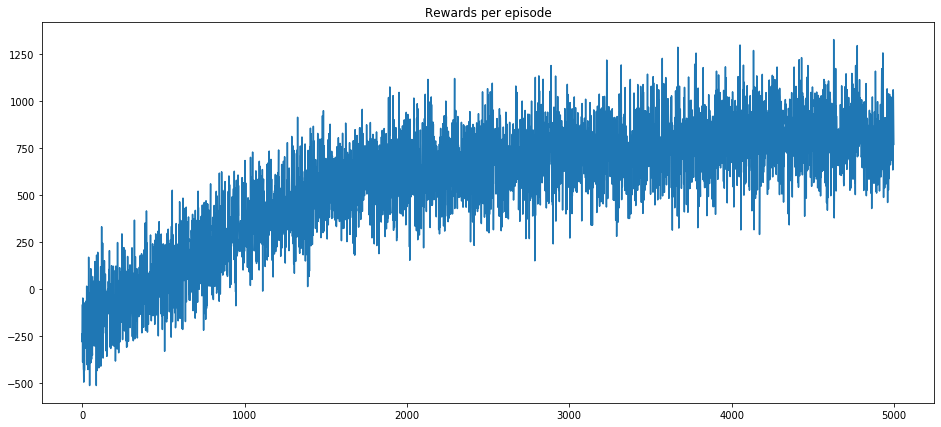

In [36]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()